In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet,LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from sklearn.model_selection import GridSearchCV,train_test_split

In [2]:
#loading Dataset
Dataset=pd.read_csv('final_dataset.csv')

In [3]:
Dataset['cell_life']=np.log10(Dataset['cell_life'])

In [4]:
Dataset

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Discharge_Cap_2,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
0,b1c0,3.267641,-2.050261,-5.051527,-0.138643,-0.040960,-0.000207,1.091144,1.071900,0.006393,13.374894,41876.171150,0.016444,-0.000075
1,b1c1,3.334454,-2.045150,-5.135776,-0.499000,0.016426,0.000006,1.080965,1.076612,0.007977,13.409150,41484.509937,0.016764,-0.000042
2,b1c2,3.349666,-1.986994,-4.951883,-0.359039,0.069572,0.000010,1.084846,1.081315,0.006738,13.358242,41694.991899,0.016613,-0.000014
3,b1c3,3.156549,-1.703321,-4.386348,-0.322093,0.050851,0.000017,1.084075,1.081228,0.005025,12.025140,35729.237342,0.016098,0.000039
4,b1c4,3.232742,-1.837397,-4.604779,-0.456945,0.133910,0.000019,1.081875,1.079012,0.005304,12.041851,37527.249169,0.016369,-0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,b3c41,2.895423,-1.608813,-4.199350,-0.511520,0.040280,0.000010,1.053878,1.051434,0.003450,10.042974,33447.610799,0.017007,-0.000173
120,b3c42,3.215373,-2.233379,-4.384951,-0.781039,0.437447,0.000002,1.069428,1.067686,0.002303,11.038937,36099.127665,0.015754,-0.000562
121,b3c43,3.019532,-1.699730,-4.152156,-0.477362,-0.283129,0.000003,1.072729,1.070812,0.002522,10.043888,33702.801503,0.015550,-0.000145
122,b3c44,2.973128,-1.584652,-4.133081,-0.665259,0.090173,0.000005,1.073078,1.070332,0.003573,10.043436,33160.813144,0.015517,-0.000106


In [5]:
numBat1=41
numBat2=43
numBat3=40
numBat=numBat1+numBat2+numBat3
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

In [6]:
#choosing model features 

varmod_features=['variance_dQ_100_10']

dismod_features=['minimum_dQ_100_10',
                 'variance_dQ_100_10',
                 'skewness_dQ_100_10',
                'kurtosis_dQ_100_10',
                'Discharge_Cap_2',
                'Diff_MaxCap_DC2']

full_features=['minimum_dQ_100_10',
               'variance_dQ_100_10',
               'Slope_Cap_Fade_2_100',
               'Intercept_Cap_Fade_2_100',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_100',
               'Min_IR',
               'Diff_IR_2_100']

target_features=['cell_life']

In [7]:
#Model
def mod(features,target,params,name):
    
    X_train=Training_Data[features]
    y_train=Training_Data[target]
    X_test=Testing_Data[features]
    y_test=Testing_Data[target]
    X_sec=Secondary_Data[features]
    y_sec=Secondary_Data[target]
    
    RMSE=list()
    MPE=list()
    
    regression=ElasticNet(max_iter=50000,random_state=0,normalize=True)
    grid=GridSearchCV(estimator=regression,
                  param_grid=params,
                 cv=5,iid=False)
    
    grid.fit(X_train,y_train)

    print(grid.score(X_train,y_train))
    print(grid.best_params_)
    
    y_pred_train=10**(grid.predict(X_train))
    y_pred_test=10**(grid.predict(X_test))
    y_pred_sec=10**(grid.predict(X_sec))
    
    y_train=10**(y_train)
    y_test=10**(y_test)
    y_sec=10**(y_sec)
    
    RMSE.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    MPE.append(float(np.mean(np.abs((y_train - y_pred_train.reshape(-1,1))) / y_train * 100)))
    
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    MPE.append(float(np.mean(np.abs((y_test - y_pred_test.reshape(-1,1))) / y_test * 100)))

    RMSE.append(np.sqrt(mean_squared_error(y_sec, y_pred_sec)))
    MPE.append(float(np.mean(np.abs((y_sec - y_pred_sec.reshape(-1,1))) / y_sec * 100)))

    plt.figure(figsize=(5,5)) 
    plt.xlabel('Observed Cycle Life')
    plt.ylabel('Predicted Cycle Life')
    plt.scatter(x=y_train,y=y_pred_train,marker='o',c='blue',s=100)
    plt.scatter(x=y_test,y=y_pred_test,marker='s',c='red',s=100)
    plt.scatter(x=y_sec,y=y_pred_sec,marker='^',c='orange',s=100)
    plt.xlim(0,2500)
    plt.ylim(0,2500)
    plt.plot(range(2500),c='black')
    plt.savefig(name, dpi=1200,pad_inches=0.2)
    plt.show()
    return np.round(RMSE,decimals=1),np.round(MPE,decimals=1)

C:\Users\Rochan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


0.8636647255400585
{'alpha': 0.001, 'l1_ratio': 0.2}


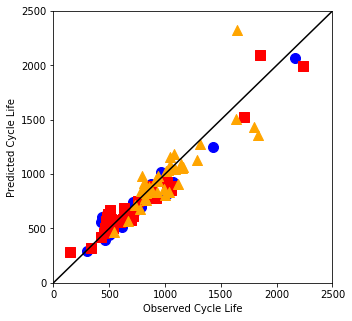

In [8]:
dis_paras={'alpha':np.linspace(0.001,0.01,10),
          'l1_ratio':np.linspace(0.1,1,10)}
dis_rmse,dis_mpe=mod(dismod_features,target_features,dis_paras,'Discharge_Model.jpeg')

C:\Users\Rochan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


0.7532105933988529
{'alpha': 0.0001, 'l1_ratio': 0.1}


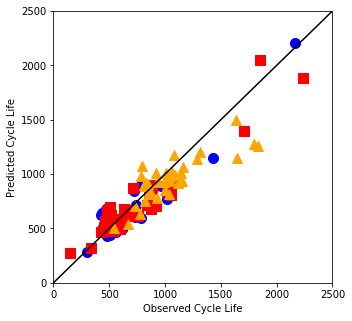

In [9]:
var_params={'alpha':np.linspace(0.0001,0.01,10),
       'l1_ratio':np.linspace(0.1,1,10)}
var_rmse,var_mpe=mod(varmod_features,target_features,var_params,'Variance_Model.jpeg')

C:\Users\Rochan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


0.9346003724915563
{'alpha': 0.0001, 'l1_ratio': 1.0}


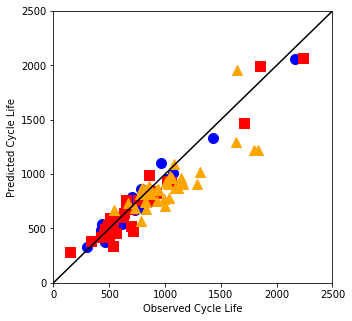

In [10]:
full_params={'alpha':np.linspace(0.0001,1,10),
       'l1_ratio':np.linspace(0.1,1,10)}
full_rmse,full_mpe=mod(full_features,target_features,full_params,'Full_Model.jpeg')

In [11]:
pd.DataFrame({"Model":["Variance model", "Discharge model", "Full model"],
              "RMSE - Train": [var_rmse[0],dis_rmse[0],full_rmse[0]],
              "RMSE - Primary test": [var_rmse[1],dis_rmse[1],full_rmse[1]],
              "RMSE - Secondary test": [var_rmse[2],dis_rmse[2],full_rmse[2]],
              "MPE - Train": [var_mpe[0],dis_mpe[0],full_mpe[0]],
              "MPE - Primary test": [var_mpe[1],dis_mpe[1],full_mpe[1]],
              "MPE - Secondary test": [var_mpe[2],dis_mpe[2],full_mpe[2]]})                                                                       

,Model,RMSE - Train,RMSE - Primary test,RMSE - Secondary test,MPE - Train,MPE - Primary test,MPE - Secondary test
0,Variance model,122.1,137.0,184.3,16.1,17.1,11.7
1,Discharge model,87.6,97.4,170.1,11.6,11.8,9.3
2,Full model,61.1,95.2,213.4,7.9,10.9,14.0
